In [8]:
import tensorflow as tf
import pydot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from sklearn.model_selection import train_test_split

In [21]:
def format_output(data):
    y1= data.pop('Y1')
    y1= np.array(y1)
    y2= data.pop('Y2')
    y2= np.array(y2)
    return y1, y2


def norm(x):
    return(x - train_stats['mean'])/train_stats['std']

def plot_diff(y_true, y_pred,  title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()
    
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()
    

In [10]:
URI = 'ENB2012_data.xlsx'

df = pd.read_excel(URI)
# df = df.sample(frac=1).reset_index(drop=True)
df = df.iloc[:,:10]


train,test = train_test_split(df,test_size=0.2)
train_stats = train.describe()

train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

norm_train_X = norm(train)
norm_test_X = norm(test)

In [11]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [12]:
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

y2_output = Dense(units='1', name='y2_output')(third_dense)

model = Model(inputs=input_layer , outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

In [13]:
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer= optimizer, 
              loss={'y1_output':'mse', 'y2_output':'mse'},
              metrics={'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output':tf.keras.metrics.RootMeanSquaredError()})

In [18]:
history = model.fit(norm_train_X, train_Y,
                   epochs = 500, batch_size = 10, validation_data =(norm_test_X, test_Y), verbose=0)

In [19]:
loss, Y1_loss, Y2_loss,Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 0.4338 - y1_output_loss: 0.1733 - y2_output_loss: 0.2605 - y1_output_root_mean_squared_error: 0.4163 - y2_output_root_mean_squared_error: 0.5104
Loss = 0.4338405728340149, Y1_loss = 0.1733001321554184, Y1_mse = 0.41629332304000854, Y2_loss = 0.2605404257774353, Y2_mse = 0.5104315876960754


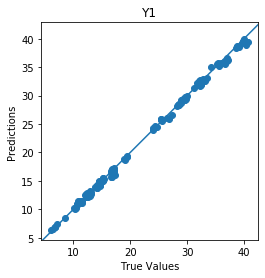

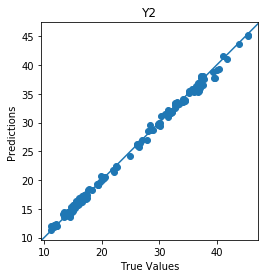

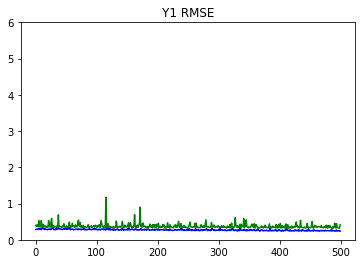

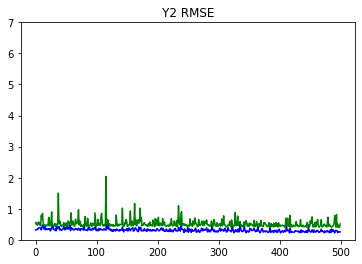

In [22]:
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)